In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dolphin import interferogram, timeseries

plt.style.use("fivethirtyeight")
%matplotlib inline

# Using $L_1$ norm timeseries inversion to preserve unwrapped congruence

## Background

The setup for our problem closely follows [@Lauknes2011InSARDeformationTime], who used the $L_1$ norm as the minimization criteria for the Small Baseline Subset (SBAS) method. Two differences are
1. The input interferograms are formed after a phase linking optimization; therefore, they contain no phase misclosure, and all residuals are multiples of $2\pi$.
2. Since most processing with Sentinel-1 data can use well-connected network, we use the incidence matrix ($A$ from [@Berardino2002NewAlgorithmSurface]), rather than the matrix of velocity differences.

## Problem statement

Let $\boldsymbol{\psi} = [\psi_{1}, \psi_{2}, ..., \psi_{N}]^{T} $ be a vector of wrapped phase from one pixel resulting from phase linking $N$ coregistered SAR images. 

We may wish to create a set of $M$ shorter baseline interferograms to ease the unwrapping process. Since there is no phase misclosure in the interferogram set, the vector of unwrapped phase $\boldsymbol{ d\phi}$ is equal to the wrapped phase differences, $\boldsymbol{d\psi}$, plus some $2 \pi$ ambiguity errors if any unwrapping errors occurred:

$$
\boldsymbol{d\psi} = \begin{bmatrix}
\psi_{1,2} \\ \psi_{1,3} \\ \psi_{1,4} \\ \psi_{2,3} \\ \dots \\ \psi_{N-1,N}
\end{bmatrix}
$$ 
Unwrapping these interferograms gives $\boldsymbol{d\phi} = \boldsymbol{d\psi} + 2 \pi \mathbf{k}$, where $\mathbf{k}=[k_{1,2}, \dots, k_{N-1,N}]$ is the ambiguity number solved by the phase unwrapper.

Let $A$ be the incidence matrix containing a $-1$ and $+1$ in the columns corresponding to the reference and secondary dates, respectively. Relabelling $\boldsymbol{d\phi}$ as the data vector $b$, we wish to minimize the difference between $A x$ and $b$.
Rather than use least squares (which minimizes the $L-2$ norm of |Ax - b|) we will minimize the $L-1$ norm; this problem is also called the Least Absolute Deviations (LAD) problem.

## Algorithm
We can minimize $|Ax - b|_1$ at each pixel independently using the [alternating direction method of multipliers (ADMM) algorithm](https://web.stanford.edu/~boyd/papers/admm/). See [@Boyd2010DistributedOptimizationStatistical] for a full description and background to the algorithm. The authors provide further [ADMM examples here](https://web.stanford.edu/~boyd/papers/admm/), as well as a [MATLAB implementation of LAD here](https://web.stanford.edu/~boyd/papers/admm/least_abs_deviations/lad.html).


In [80]:
np.random.seed(3)

In [82]:
N = 3
days = np.arange(N+1)

ifg_list = interferogram.Network.all_pairs(days)
M = len(ifg_list)
A = timeseries.get_incidence_matrix(ifg_list)

In [83]:
x_true = np.concatenate([[0], np.random.randn(N)])

Text(0, 0.5, 'cycles')

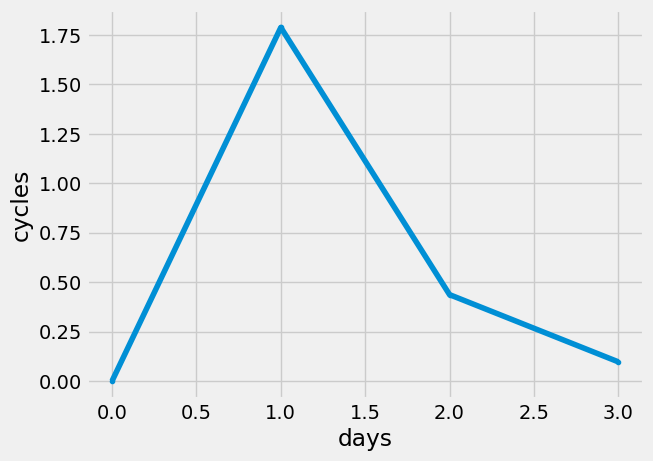

In [84]:
fig, ax = plt.subplots()
ax.plot(days, x_true, '.-')
ax.set_xlabel("days")
ax.set_ylabel("cycles")

In [85]:
def create_noisy_data(A, x_true, pct_errors = 0.1):
    """Make a vector of truth data, and one with unwrapping errors."""
    # b_true = np.array([.1, .3, .2, .2, .1, -.1])
    b_true = A @ x_true[1:]

    has_unwrapping_error = np.random.random(size=b_true.shape) < pct_errors
    integer_ambiguity_errors = np.random.randint(low=1, high=10, size=b_true.shape)
    k_noise = integer_ambiguity_errors * has_unwrapping_error

    b = b_true + k_noise
    assert np.allclose((b - A @ x_true[1:]),  k_noise)
    return b, b_true


In [86]:
b, b_true = create_noisy_data(A, x_true)

By solving the least absolute deviations problem, we come up with a sparse residual vector. In this case, it means that we perfectly reconstruct $x$ by ignoring the large single unwrapping error:

In [153]:
R = np.linalg.cholesky(A.T @ A)
x_hat, r0 = timeseries.least_absolute_deviations(A, b, R)
print(f"True x: {x_true.round(3)}")
print(f"Estimate of x: {x_hat.round(3)}")
print(f"Difference: {(x_true[1:] - x_hat).round(2)}")

True x: [ 0.     1.549  0.696 -0.843 -0.249 -0.557  0.485 -1.394 -1.692  0.176
 -0.122  1.08   0.455  1.572  0.956  1.593  0.271 -1.633 -0.527 -2.157
  0.735  1.424 -0.091 -1.28   0.748  0.688 -0.248  0.522  0.139 -0.201
  0.204  0.786 -0.451 -1.443  0.136  1.09  -0.945  0.364  0.297  0.385
  0.075  0.505 -0.943 -1.107 -0.835 -1.541  0.065  0.207 -1.159  2.03
 -0.206]

Estimate of x: [ 1.549       0.69600004 -0.84200007 -0.25       -0.55700004  0.485
 -1.394      -1.692       0.177      -0.12200001  1.08        0.455
  1.5730001   0.95600003  1.593       0.27100003 -1.6330001  -0.527
 -2.1560001   0.734       1.424      -0.09100001 -1.281       0.748
  0.688      -0.24800001  0.522       0.13800001 -0.201       0.20400001
  0.786      -0.45100003 -1.4430001   0.13700001  1.09       -0.94500005
  0.36400002  0.29700002  0.384       0.074       0.505      -0.94200003
 -1.107      -0.83500004 -1.5410001   0.06500001  0.20700002 -1.159
  2.029      -0.20600002]

Difference: [-0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0.  0. -0.
 -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0.
  0. -0.  0.  0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.]

In [73]:
print(f"Residuals: {r0.round(3)}")
print("Residuals from the truth:")
print((A@x_hat - b_true).round(3))

Residuals: [0.    0.    0.    0.    2.999 0.   ]

Residuals from the truth:

[-0.    -0.     0.     0.     0.001  0.   ]

If we use least squares to perform the inversion, the errors are smeared out over multiple elements of $x$:

In [66]:
x_l2 = np.linalg.lstsq(A, b, rcond=None)[0]

print(f"Estimate using least squares: {x_l2}")
print(f"Difference: {(x_true[1:] - x_l2).round(2)}")


Estimate using least squares: [1.03862847 0.43650985 0.84649747]

Difference: [ 0.75  0.   -0.75]

## Larger system, more errors

In [166]:
N = 50
days = np.arange(N+1)
ifg_list = interferogram.Network.all_pairs(days)
M = len(ifg_list)
A = timeseries.get_incidence_matrix(ifg_list)

x_true = np.concatenate([[0], np.random.randn(N)])
b, b_true = create_noisy_data(A, x_true, 0.3)

In [167]:
print(b.shape, np.nonzero(b - b_true)[0].shape)

(1275,)
(365,)

In [168]:
x_hat, r0 = timeseries.least_absolute_deviations(A, b, R)
print(f"True x: {x_true.round(3)}")
print(f"Estimate of x: {x_hat.round(3)}")
print(f"Difference: {(x_true[1:] - x_hat).round(2)}")

True x: [ 0.    -0.848 -0.006 -0.755  1.844 -0.641 -0.135  0.382 -1.212  0.86
 -0.73   1.449  1.324  0.718  0.634 -0.46   0.102  0.583  0.566 -0.026
  0.947 -0.092  0.28  -1.391  1.856  0.386  0.327  0.301  1.443 -1.595
 -0.848 -0.583  0.344  0.334  2.149 -0.318 -1.328 -0.16  -0.281  0.696
  0.265 -0.33  -1.857 -0.054 -1.366 -0.073 -0.175  2.153 -0.439  1.092
  2.602]

Estimate of x: [-0.84900004 -0.005      -0.75500005  1.8440001  -0.64100003 -0.134
  0.38200003 -1.2110001   0.86       -0.731       1.4490001   1.3240001
  0.71800005  0.634      -0.46        0.10200001  0.583       0.56600004
 -0.026       0.947      -0.09200001  0.279      -1.391       1.8560001
  0.386       0.32700002  0.30100003  1.4430001  -1.5960001  -0.84900004
 -0.58400005  0.344       0.33400002  2.1490002  -0.319      -1.3280001
 -0.16000001 -0.28100002  0.69600004  0.26500002 -0.33       -1.8570001
 -0.054      -1.366      -0.074      -0.17500001  2.1520002  -0.44000003
  1.092       2.6020002 ]

Difference: [ 0. -0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0.
  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.]

In [169]:
x_l2 = np.linalg.lstsq(A, b, rcond=None)[0]

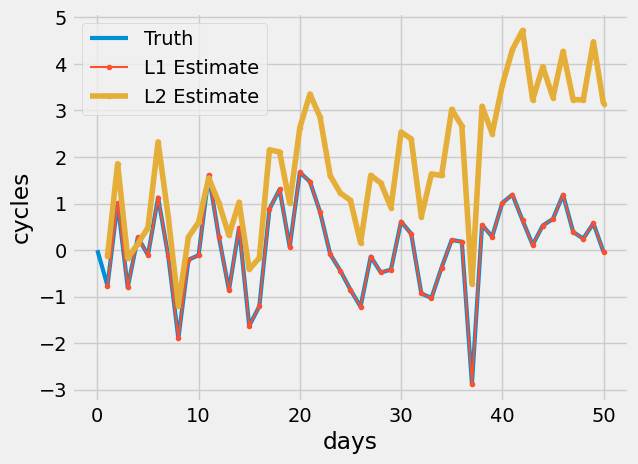

In [158]:
fig, ax = plt.subplots()

ax.plot(days, x_true, '-', label='Truth', lw=3)
ax.plot(days[1:], x_hat, '.-', label='L1 Estimate', lw=1.5)
ax.plot(days[1:], x_l2, '.-', label='L2 Estimate')

ax.set_xlabel("days")
ax.set_ylabel("cycles")
ax.legend()

## Runtimes vs least squares

In [171]:
%%timeit
np.linalg.lstsq(A, b, rcond=None)[0]

5.52 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [170]:
%%timeit
timeseries.least_absolute_deviations(A, b, R)

1.76 ms ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We see that the JAX implementation of LAD can run faster than a call to NumPy's `lstsq`. In general, we don't expect LAD to run faster than least squares when solving many pixels with the same `A` matrix, as each call is dominated by a factorization of `A`. However, the ADMM implementation can run over 10 times as fast as the [Iteratively reweighted least squares (IRLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) algorithm, which must solve many least squares problems with a different left hand side each time.